# 📨 Spam Email Classifier (SEC)


In [1]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from textblob import Word
from nltk.corpus import stopwords
import argparse
import mlflow
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,  mean_squared_error
from prefect_great_expectations import run_checkpoint_validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


True

## Downloading the dataset

In [3]:
%pwd

'/app/lab'

In [4]:
outpout_dir = 'data'
os.makedirs(outpout_dir, exist_ok=True)



In [5]:
url = "https://drive.google.com/file/d/1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy/view?usp=sharing"
output = "data/spam_emails_1.csv"

gdown.download(url, output, quiet=False , fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1wtogytIpZC74Tq6s1GWaPWY3VBhmOrJy
To: /app/lab/data/spam_emails_1.csv
100%|██████████| 5.50M/5.50M [00:02<00:00, 2.59MB/s]


'data/spam_emails_1.csv'

In [6]:
%pip list | grep greate-expectations

Note: you may need to restart the kernel to use updated packages.


In [7]:
from ruamel.yaml import YAML
import great_expectations as gx
from pprint import pprint

yaml = YAML()
context = gx.get_context()

In [8]:
context.list_expectation_suite_names()

['spam_emails_1.csv.warning']

In [9]:
#context.run_checkpoint("lab_checkpoint")
#context.open_data_docs()

## Data Exploration
In this section, we will explore the dataset to get a better understanding of the data.

In [10]:

df = pd.read_csv(output)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


The dataset contains 5, 171 emails. Each email has the following attributes:

- `text`: The text of the email
- `label`: The label of the email. `1` means the email is spam, `0` means the email is not spam.

### Cleaning the data

In [12]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('label_num', axis=1, inplace=True)
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [13]:
df.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [14]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

<Axes: title={'center': 'Count (label)'}>

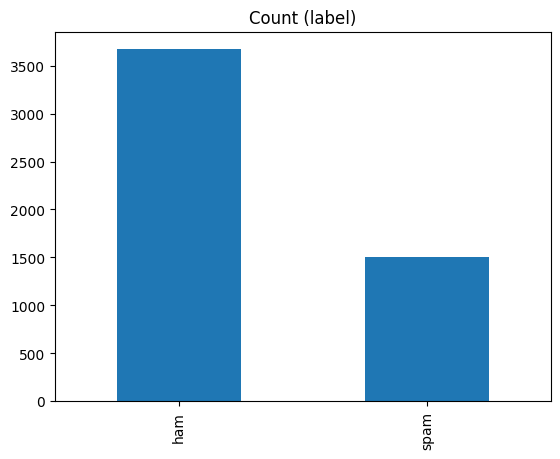

In [15]:
df['label'].value_counts().plot(kind='bar', title='Count (label)')


`NOTE`: The distribution of the labels is not balanced. There are 3672 non-spam emails and 1499 spam emails.

## Preprocessing
In this section, we will preprocess the data to make it ready for training.

We will perform the following preprocessing steps:
- Remove punctuation
- Convert the text to lowercase
- Remove stopwords
- Remove common words
- Remove rare words
- lemmatize the text

In [16]:
# remove punctuation
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head()

09:08:01.613 | WARNING | py.warnings - <>:2: DeprecationWarning: invalid escape sequence '\w'

09:08:01.622 | WARNING | py.warnings - <>:2: DeprecationWarning: invalid escape sequence '\w'

09:08:01.625 | WARNING | py.warnings - /tmp/ipykernel_1099/2903461620.py:2: DeprecationWarning: invalid escape sequence '\w'
  df['text'] = df['text'].str.replace('[^\w\s]','')

09:08:01.632 | WARNING | py.warnings - /tmp/ipykernel_1099/2903461620.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')

,label,text
0,ham,Subject enron methanol meter 988291\r\nthis...
1,ham,Subject hpl nom for january 9 2001\r\n see at...
2,ham,Subject neon retreat\r\nho ho ho we re aroun...
3,spam,Subject photoshop windows office cheap mai...
4,ham,Subject re indian springs\r\nthis deal is to ...


In [17]:
# convert to lowercase
df['text'] = df['text'].str.lower()
df.head()

,label,text
0,ham,subject enron methanol meter 988291\r\nthis...
1,ham,subject hpl nom for january 9 2001\r\n see at...
2,ham,subject neon retreat\r\nho ho ho we re aroun...
3,spam,subject photoshop windows office cheap mai...
4,ham,subject re indian springs\r\nthis deal is to ...


In [18]:
# remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head()

,label,text
0,ham,subject enron methanol meter 988291 follow not...
1,ham,subject hpl nom january 9 2001 see attached fi...
2,ham,subject neon retreat ho ho ho around wonderful...
3,spam,subject photoshop windows office cheap main tr...
4,ham,subject indian springs deal book teco pvr reve...


In [19]:
# remove common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.head()

,label,text
0,ham,methanol meter 988291 follow note gave monday ...
1,ham,hpl nom january 9 2001 see attached file hplno...
2,ham,neon retreat ho ho ho around wonderful time ye...
3,spam,photoshop windows office cheap main trending a...
4,ham,indian springs deal book teco pvr revenue unde...


In [20]:
# remove rare words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.head()

,label,text
0,ham,methanol meter 988291 follow note gave monday ...
1,ham,hpl nom january 9 2001 see attached file hplno...
2,ham,neon retreat ho ho ho around wonderful time ye...
3,spam,photoshop windows office cheap main trending a...
4,ham,indian springs deal book teco pvr revenue unde...


In [21]:
# lemmatization
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()


,label,text
0,ham,methanol meter 988291 follow note gave monday ...
1,ham,hpl nom january 9 2001 see attached file hplno...
2,ham,neon retreat ho ho ho around wonderful time ye...
3,spam,photoshop window office cheap main trending ab...
4,ham,indian spring deal book teco pvr revenue under...


In [22]:
df['text'][0]

'methanol meter 988291 follow note gave monday 4 00 preliminary flow data provided daren override pop daily volume presently zero reflect daily activity obtain control change needed asap economics purpose'

## Feature Engineering
In this section, we will create features from the preprocessed text.

We will perform the following feature engineering steps:
- Vectorize the text using TF-IDF
- Encode the labels


In [23]:
df['text'][1]

'hpl nom january 9 2001 see attached file hplnol 09 xl hplnol 09 xl'

In [ ]:
%pip install wordcloud

In [46]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

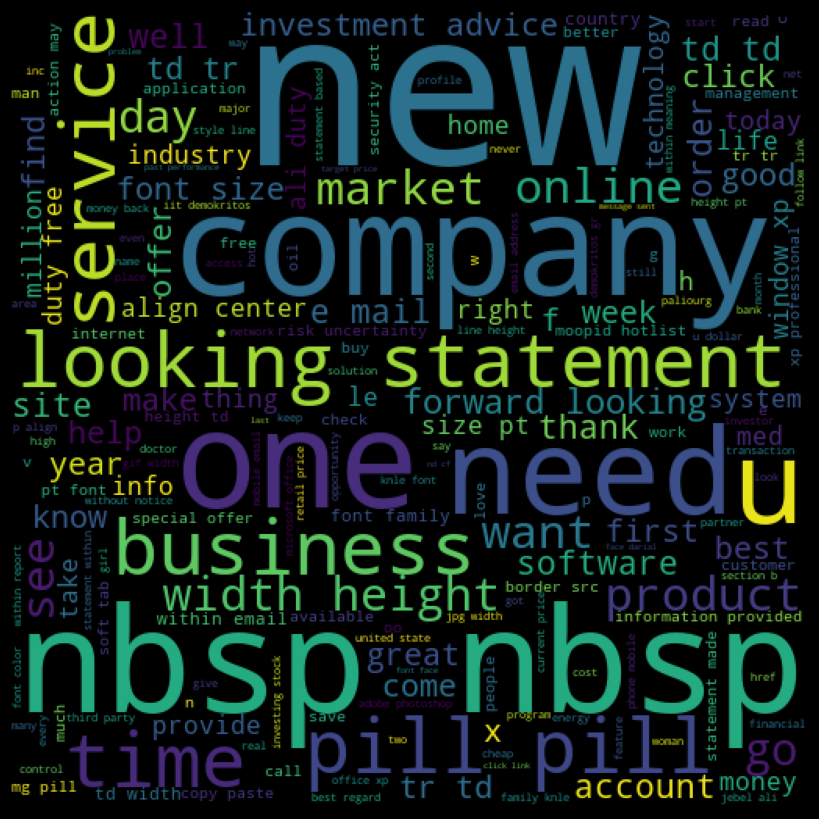

In [43]:
spam_words = ' '.join(list(df[df['label']=='spam']['text']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


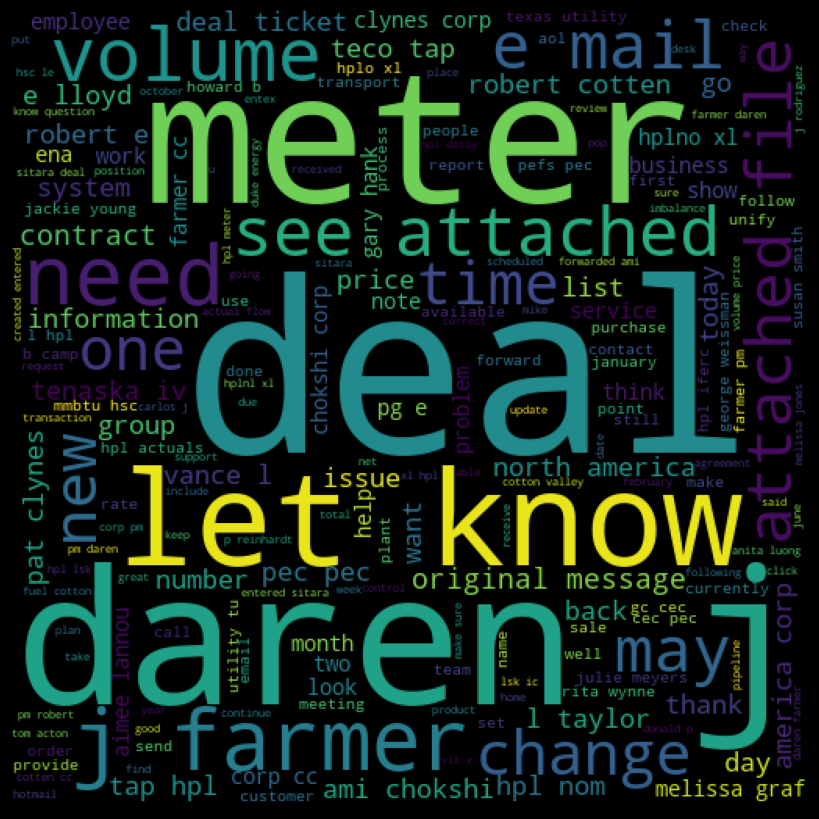

In [44]:
# I want to see the most common words in ham emails
ham_words = ' '.join(list(df[df['label']=='ham']['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


In [47]:
# encode the label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,label,text
0,0,methanol meter 988291 follow note gave monday ...
1,0,hpl nom january 9 2001 see attached file hplno...
2,0,neon retreat ho ho ho around wonderful time ye...
3,1,photoshop window office cheap main trending ab...
4,0,indian spring deal book teco pvr revenue under...


In [48]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])


## Splitting the dataset

In [49]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (4136,)
y_train shape: (4136,)
X_test shape: (1035,)
y_test shape: (1035,)


## Model Training

In [50]:
# train the model
pipeline.fit(X_train, y_train)
pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Grid search

In [51]:
# grid search
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__max_features': (1000, 2000, 3000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.001),
                         'tfidf__max_features': (1000, 2000, 3000),
                         'tfidf__ngram_range': ((1, 1), (1, 2)),
                         'tfidf__use_idf': (True, False)},
             verbose=1)

In [52]:
# print the best parameters
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best parameters set:
	clf__alpha: 0.001
	tfidf__max_features: 3000
	tfidf__ngram_range: (1, 1)
	tfidf__use_idf: False


## Model Evaluation

In [53]:
# predict the test data
y_pred = pipeline.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [54]:
# show the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

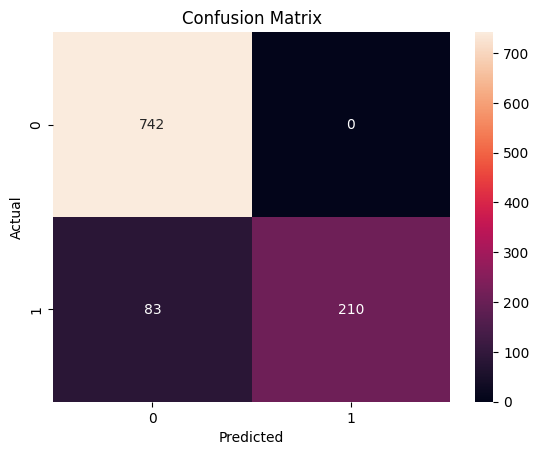

In [55]:
# plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


In [56]:
# show the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.72      0.83       293

    accuracy                           0.92      1035
   macro avg       0.95      0.86      0.89      1035
weighted avg       0.93      0.92      0.92      1035



In [57]:
# accuracy score in %
accuracy_score(y_test, y_pred) * 100


91.98067632850243

## Orchestrating the model training and evaluation

### Preprocessing and Feature Engineering

In [58]:
from prefect import task, flow
from typing import List, Dict, Any, Optional

columns_to_drop = ['Unnamed: 0', 'label_num']

@task(name='drop_columns', tags=['preprocessing'])
def drop_columns(
        df : pd.DataFrame,
        column_to_drop: list = columns_to_drop  
) -> pd.DataFrame:
        """
        Drop columns from the dataframe
        """
        df.drop(columns=column_to_drop, inplace=True)
        return df
        

In [59]:

def preprocess_text_base(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess text data
    Args:
        df (pd.DataFrame): dataframe containing text data
    Returns:
        pd.DataFrame: preprocessed dataframe
    """
    df['text'] = df['text'].astype(str)
    df['text'] = df['text'].str.replace(r'[^\w\s]', '')
    df['text'] = df['text'].str.lower()
    stop = stopwords.words('english')
    df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
    freq = list(freq.index)
    df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df

@task(name='preprocess_text', tags=['preprocessing'])
def preprocess_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess text data
    Args:
        df (pd.DataFrame): dataframe containing text data
    Returns:
        pd.DataFrame: preprocessed dataframe
    """
    return preprocess_text_base(df)



In [60]:
@task(name='extract_x_y', tags=['preprocessing'])
def extract_x_y(
        df: pd.DataFrame,
        with_target: bool = True,
) -> dict:
    """
    Extract X and y from dataframe
    Args:
        df (pd.DataFrame): dataframe containing text data
        with_target (bool): whether to extract target or not
    Returns:
        dict: dictionary containing X and y
    """
    if with_target:
        X = df['text']
        y = df['label']
    else:
        X = df['text']
        y = None

    return {'X': X, 'y': y }

In [61]:
def save_pickle(path: str, obj: dict):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [62]:
# save label encoder
local_storage = "training_data"
le_storage = os.path.join(local_storage, "tv")
le_path = os.path.join(le_storage, "label_encoder.pkl")

@task(name='save_label_encoder', tags=['preprocessing'])
def save_label_encoder(encoder : LabelEncoder, path: str) -> None:
    """
    Save label encoder
    Args:
        encoder (LabelEncoder): label encoder
        path (str): path to save the label encoder
    """
    os.makedirs(local_storage, exist_ok=True)
    os.makedirs(le_storage, exist_ok=True)    
    save_pickle(path, encoder)
 

@flow(name="Data processing")
def preprocess_data(
        path: str, 
        with_target: bool = True,
) -> dict:
    """
    Preprocess data
    Args:
        path (str): path to the data
        with_target (bool): whether to extract target or not
    Returns:
        dict: dictionary containing X and y
    """

    nltk.download('stopwords')
    nltk.download('wordnet')
    df = pd.read_csv(path)
    df = drop_columns(df)
    df = preprocess_text(df)
    
    if with_target: 
        label_encoder = LabelEncoder()
        label_encoder.fit(df['label'])
        df['label'] = label_encoder.transform(df['label'])
        save_label_encoder(label_encoder,le_path)

    return extract_x_y(df,with_target)

### Model Training

In [63]:
@flow(name="Data validation")
def data_validation(checkpoint_name: str):
    run_checkpoint_validation(checkpoint_name=checkpoint_name)


In [64]:
from scipy.sparse import csr_matrix
import numpy as np

@task(name='model_training', tags=['model'])
def model_training(X: csr_matrix, y: csr_matrix, **kwargs) -> Pipeline:
    """ 
    Train the model
    Args:
        X (csr_matrix): X data
        y (csr_matrix): y data
        **kwargs: keyword arguments
    Returns:
        Pipeline: trained model
    """

    max_features = kwargs.get('max_features', 3000)
    ngram_range = kwargs.get('ngram_range', (1, 2))
    use_idf = kwargs.get('use_idf', True)
    alpha = kwargs.get('alpha', 0.01)
    analyser = kwargs.get('analyser', 'word')
    stop_words = kwargs.get('stop_words', 'english')

    

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, 
                                ngram_range=ngram_range, 
                                use_idf=use_idf, 
                                analyzer=analyser, 
                                stop_words=stop_words)),
        ('clf', MultinomialNB(alpha=alpha)),
    ])
    pipeline.fit(X, y)
    return pipeline

In [65]:
@task(name='model_predict', tags=['model'])
def model_predict(input_data: csr_matrix, pipeline: Pipeline) -> np.ndarray:
    """ 
    Predict the model
    Args:
        input_data (csr_matrix): input data
        pipeline (Pipeline): trained model
    Returns:
        np.ndarray: predicted data
    """
    return pipeline.predict(input_data)

In [66]:
@task(name='model_evaluation', tags=['model'])
def model_evaluation(y_true : np.ndarray, y_pred : np.ndarray) -> dict:
    """
    Evaluate the model
    Args:
        y_true (np.ndarray): true labels
        y_pred (np.ndarray): predicted labels
    Returns:
        dict: dictionary containing accuracy, precision, recall and f1 score
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [67]:
@flow(name='model_training_and_evaluation')
def model_training_and_evaluation(
    X_train,
    y_train,
    X_test,
    y_test,
    **kwargs
) -> dict:
    """
    Train and evaluate the model
    Args:
        X_train (csr_matrix): X train data
        y_train (csr_matrix): y train data
        X_test (csr_matrix): X test data
        y_test (csr_matrix): y test data
        **kwargs: keyword arguments
    Returns:
        dict: dictionary containing accuracy, precision, recall and f1 score
    """

    pipeline = model_training(X_train, y_train, **kwargs)
    y_pred =  model_predict(X_test, pipeline)
    evaluate = model_evaluation(y_test, y_pred)
    return  {'evaluate': evaluate, 'pipeline': pipeline}

In [68]:

@task(name="Load", tags=['Serialize'])
def task_load_pickle(path: str):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
    return loaded_obj


@task(name="Save", tags=['Serialize'])
def task_save_pickle(path: str, obj: dict):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [69]:


model_storage = os.path.join(local_storage, "model")
model_path = os.path.join(model_storage, "model.pkl")


print(f"tracking URI: '{mlflow.get_tracking_uri()}'")


tracking URI: 'file:///app/lab/mlruns'


In [70]:
@flow(name='Model Training')
def train_model(
    data_path: str, 
    local_storage: str = local_storage,
    save_model: bool = True , 
    **kwargs
) -> None:
    """ 
    Train model and save model and text vectorizer
    Args:
        data_path (str): path to data
        local_storage (str): path to local storage
        save_model (bool): save model
        **kwargs: keyword arguments, passed to preprocess_data and model_training_and_evaluation functions. \
            These are the arguments of the TfidfVectorizer class.
    Returns:
        None
    """

    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(f'email_spam_lab')

    with mlflow.start_run() as run:
        run_id = run.info.run_id
        mlflow.set_tag("Level", "Development")

        extract_data = preprocess_data(data_path, True)

        X = extract_data['X']
        y = extract_data['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        mlflow.log_param("train_set_size", X_train.shape[0])
        mlflow.log_param("test_set_size", X_test.shape[0])

        results = model_training_and_evaluation(X_train, y_train, X_test, y_test, **kwargs)

        mlflow.log_metric("accuracy", results['evaluate']['accuracy'])
        mlflow.log_metric("precision", results['evaluate']['precision'])
        mlflow.log_metric("recall", results['evaluate']['recall'])
        mlflow.log_metric("f1", results['evaluate']['f1'])

        os.makedirs(local_storage, exist_ok=True)
        os.makedirs(model_storage, exist_ok=True)

        mlflow.sklearn.log_model(results['pipeline'], "models")
        mlflow.register_model(f"runs:/{run_id}/models", "email_spam_model")

        if save_model:  task_save_pickle(model_path, results['pipeline'])

        return results

       

In [71]:
@flow(name='Batch Inference')
def batch_inference(input_path: str, model=None) :
    """ Batch inference """
    if model is None: model = task_load_pickle(model_path)
    data = preprocess_data(input_path, False)
    return model_predict(data['X'], model)

## Servers for orchestration

Run mlflow and prefect servers the scripts in `init_mlflow.py` and `init_orion.py` respectively in two separate terminals.
    
    ```bash
    python init_mlflow.py
    ```

    ```bash
    python init_orion.py
    ```
    
    


### Data validation flow

In [72]:
data_validation("lab_checkpoint")

11:34:01.195 | INFO    | prefect.engine - Created flow run 'quizzical-mantis' for flow 'Data validation'

11:34:01.782 | INFO    | Flow run 'quizzical-mantis' - Created task run 'run_checkpoint_validation-0' for task 'run_checkpoint_validation'

11:34:01.789 | INFO    | Flow run 'quizzical-mantis' - Executing 'run_checkpoint_validation-0' immediately...

11:34:01.993 | INFO    | Task run 'run_checkpoint_validation-0' - Running Great Expectations validation...

Calculating Metrics:   0%|          | 0/47 [00:00<?, ?it/s]

11:34:10.965 | INFO    | Task run 'run_checkpoint_validation-0' - Great Expectations validation run 20230330-113402-my-run-name-template succeeded

11:34:11.083 | INFO    | Task run 'run_checkpoint_validation-0' - Finished in state Completed()

11:34:11.199 | INFO    | Flow run 'quizzical-mantis' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `CheckpointResult`'))]

In [212]:
output

'data/spam_emails_1.csv'

In [216]:
train_model(output, save_model=False , max_features=1000, ngram_range=(1, 2), use_idf=True, analyser='word', stop_words='english')

02:01:56.353 | INFO    | prefect.engine - Created flow run 'violet-rhino' for flow 'Model Training'

02:01:59.122 | WARNING | py.warnings - /opt/conda/lib/python3.10/site-packages/prefect/tasks.py:270: UserWarning: A task named 'Data processing' and defined at '/tmp/ipykernel_1100/1809663541.py:19' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(

02:01:59.351 | INFO    | Flow run 'violet-rhino' - Created subflow run 'daft-kagu' for flow 'Data processing'

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


02:01:59.766 | INFO    | Flow run 'daft-kagu' - Created task run 'drop_columns-0' for task 'drop_columns'

02:01:59.771 | INFO    | Flow run 'daft-kagu' - Executing 'drop_columns-0' immediately...

02:01:59.969 | INFO    | Task run 'drop_columns-0' - Finished in state Completed()

02:02:00.053 | INFO    | Flow run 'daft-kagu' - Created task run 'preprocess_text-0' for task 'preprocess_text'

02:02:00.057 | INFO    | Flow run 'daft-kagu' - Executing 'preprocess_text-0' immediately...

02:02:00.208 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

02:02:09.707 | INFO    | Task run 'preprocess_text-0' - Finished in state Completed()

02:02:09.793 | INFO    | Flow run 'daft-kagu' - Created task run 'save_label_encoder-0' for task 'save_label_encoder'

02:02:09.796 | INFO    | Flow run 'daft-kagu' - Executing 'save_label_encoder-0' immediately...

02:02:10.032 | INFO    | Task run 'save_label_encoder-0' - Finished in state Completed()

02:02:10.094 | INFO    | Flow run 'daft-kagu' - Created task run 'extract_x_y-0' for task 'extract_x_y'

02:02:10.098 | INFO    | Flow run 'daft-kagu' - Executing 'extract_x_y-0' immediately...

02:02:10.281 | INFO    | Task run 'extract_x_y-0' - Finished in state Completed()

02:02:10.417 | INFO    | Flow run 'daft-kagu' - Finished in state Completed()

02:02:11.173 | WARNING | py.warnings - /opt/conda/lib/python3.10/site-packages/prefect/tasks.py:270: UserWarning: A task named 'model_training_and_evaluation' and defined at '/tmp/ipykernel_1100/2663536112.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(

02:02:11.882 | INFO    | Flow run 'violet-rhino' - Created subflow run 'cryptic-pegasus' for flow 'model_training_and_evaluation'

02:02:12.402 | INFO    | Flow run 'cryptic-pegasus' - Created task run 'model_training-0' for task 'model_training'

02:02:12.406 | INFO    | Flow run 'cryptic-pegasus' - Executing 'model_training-0' immediately...

02:02:14.778 | INFO    | Task run 'model_training-0' - Finished in state Completed()

02:02:14.830 | INFO    | Flow run 'cryptic-pegasus' - Created task run 'model_predict-0' for task 'model_predict'

02:02:14.832 | INFO    | Flow run 'cryptic-pegasus' - Executing 'model_predict-0' immediately...

02:02:15.265 | INFO    | Task run 'model_predict-0' - Finished in state Completed()

02:02:15.322 | INFO    | Flow run 'cryptic-pegasus' - Created task run 'model_evaluation-0' for task 'model_evaluation'

02:02:15.328 | INFO    | Flow run 'cryptic-pegasus' - Executing 'model_evaluation-0' immediately...

02:02:15.583 | INFO    | Task run 'model_evaluation-0' - Finished in state Completed()

02:02:15.772 | INFO    | Flow run 'cryptic-pegasus' - Finished in state Completed()

Registered model 'email_spam_model' already exists. Creating a new version of this model...
2023/03/21 02:02:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: email_spam_model, version 5
Created version '5' of model 'email_spam_model'.


02:02:28.368 | INFO    | Flow run 'violet-rhino' - Finished in state Completed()

{'evaluate': {'accuracy': 0.957487922705314,
  'precision': 0.8952380952380953,
  'recall': 0.962457337883959,
  'f1': 0.9276315789473685},
 'pipeline': Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('clf', MultinomialNB(alpha=0.01))])}

In [217]:
# Use different parameters
train_model(output, save_model=True , max_features=1000, ngram_range=(1, 2), use_idf=False, analyser='word', stop_words='english')

02:02:39.511 | INFO    | prefect.engine - Created flow run 'glaring-coyote' for flow 'Model Training'

02:02:42.267 | WARNING | py.warnings - /opt/conda/lib/python3.10/site-packages/prefect/tasks.py:270: UserWarning: A task named 'Data processing' and defined at '/tmp/ipykernel_1100/1809663541.py:19' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(

02:02:42.463 | INFO    | Flow run 'glaring-coyote' - Created subflow run 'strange-junglefowl' for flow 'Data processing'

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


02:02:42.823 | INFO    | Flow run 'strange-junglefowl' - Created task run 'drop_columns-0' for task 'drop_columns'

02:02:42.828 | INFO    | Flow run 'strange-junglefowl' - Executing 'drop_columns-0' immediately...

02:02:43.026 | INFO    | Task run 'drop_columns-0' - Finished in state Completed()

02:02:43.089 | INFO    | Flow run 'strange-junglefowl' - Created task run 'preprocess_text-0' for task 'preprocess_text'

02:02:43.093 | INFO    | Flow run 'strange-junglefowl' - Executing 'preprocess_text-0' immediately...

02:02:43.216 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

02:02:53.392 | INFO    | Task run 'preprocess_text-0' - Finished in state Completed()

02:02:53.470 | INFO    | Flow run 'strange-junglefowl' - Created task run 'save_label_encoder-0' for task 'save_label_encoder'

02:02:53.475 | INFO    | Flow run 'strange-junglefowl' - Executing 'save_label_encoder-0' immediately...

02:02:53.774 | INFO    | Task run 'save_label_encoder-0' - Finished in state Completed()

02:02:53.870 | INFO    | Flow run 'strange-junglefowl' - Created task run 'extract_x_y-0' for task 'extract_x_y'

02:02:53.878 | INFO    | Flow run 'strange-junglefowl' - Executing 'extract_x_y-0' immediately...

02:02:54.277 | INFO    | Task run 'extract_x_y-0' - Finished in state Completed()

02:02:54.537 | INFO    | Flow run 'strange-junglefowl' - Finished in state Completed()

02:02:55.890 | WARNING | py.warnings - /opt/conda/lib/python3.10/site-packages/prefect/tasks.py:270: UserWarning: A task named 'model_training_and_evaluation' and defined at '/tmp/ipykernel_1100/2663536112.py:1' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(

02:02:58.027 | INFO    | Flow run 'glaring-coyote' - Created subflow run 'loud-silkworm' for flow 'model_training_and_evaluation'

02:02:58.786 | INFO    | Flow run 'loud-silkworm' - Created task run 'model_training-0' for task 'model_training'

02:02:58.795 | INFO    | Flow run 'loud-silkworm' - Executing 'model_training-0' immediately...

02:03:02.990 | INFO    | Task run 'model_training-0' - Finished in state Completed()

02:03:03.208 | INFO    | Flow run 'loud-silkworm' - Created task run 'model_predict-0' for task 'model_predict'

02:03:03.216 | INFO    | Flow run 'loud-silkworm' - Executing 'model_predict-0' immediately...

02:03:04.088 | INFO    | Task run 'model_predict-0' - Finished in state Completed()

02:03:04.240 | INFO    | Flow run 'loud-silkworm' - Created task run 'model_evaluation-0' for task 'model_evaluation'

02:03:04.249 | INFO    | Flow run 'loud-silkworm' - Executing 'model_evaluation-0' immediately...

02:03:04.689 | INFO    | Task run 'model_evaluation-0' - Finished in state Completed()

02:03:04.963 | INFO    | Flow run 'loud-silkworm' - Finished in state Completed()

Registered model 'email_spam_model' already exists. Creating a new version of this model...
2023/03/21 02:03:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: email_spam_model, version 6
Created version '6' of model 'email_spam_model'.


02:03:20.968 | INFO    | Flow run 'glaring-coyote' - Created task run 'Save-0' for task 'Save'

02:03:20.975 | INFO    | Flow run 'glaring-coyote' - Executing 'Save-0' immediately...

02:03:21.750 | INFO    | Task run 'Save-0' - Finished in state Completed()

02:03:22.531 | INFO    | Flow run 'glaring-coyote' - Finished in state Completed()

{'evaluate': {'accuracy': 0.9429951690821256,
  'precision': 0.8979591836734694,
  'recall': 0.9010238907849829,
  'f1': 0.899488926746167},
 'pipeline': Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                  stop_words='english', use_idf=False)),
                 ('clf', MultinomialNB(alpha=0.01))])}

In [218]:

inference = batch_inference(output)

02:03:46.446 | INFO    | prefect.engine - Created flow run 'cherubic-macaque' for flow 'Batch Inference'

02:03:46.893 | INFO    | Flow run 'cherubic-macaque' - Created task run 'Load-0' for task 'Load'

02:03:46.897 | INFO    | Flow run 'cherubic-macaque' - Executing 'Load-0' immediately...

02:03:47.298 | INFO    | Task run 'Load-0' - Finished in state Completed()

02:03:47.358 | WARNING | py.warnings - /opt/conda/lib/python3.10/site-packages/prefect/tasks.py:270: UserWarning: A task named 'Data processing' and defined at '/tmp/ipykernel_1100/1809663541.py:19' conflicts with another task. Consider specifying a unique `name` parameter in the task definition:

 `@task(name='my_unique_name', ...)`
  warnings.warn(

02:03:47.577 | INFO    | Flow run 'cherubic-macaque' - Created subflow run 'complex-potoo' for flow 'Data processing'

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


02:03:47.962 | INFO    | Flow run 'complex-potoo' - Created task run 'drop_columns-0' for task 'drop_columns'

02:03:47.969 | INFO    | Flow run 'complex-potoo' - Executing 'drop_columns-0' immediately...

02:03:48.225 | INFO    | Task run 'drop_columns-0' - Finished in state Completed()

02:03:48.314 | INFO    | Flow run 'complex-potoo' - Created task run 'preprocess_text-0' for task 'preprocess_text'

02:03:48.319 | INFO    | Flow run 'complex-potoo' - Executing 'preprocess_text-0' immediately...

02:03:48.555 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

02:03:59.411 | INFO    | Task run 'preprocess_text-0' - Finished in state Completed()

02:03:59.488 | INFO    | Flow run 'complex-potoo' - Created task run 'extract_x_y-0' for task 'extract_x_y'

02:03:59.493 | INFO    | Flow run 'complex-potoo' - Executing 'extract_x_y-0' immediately...

02:03:59.710 | INFO    | Task run 'extract_x_y-0' - Finished in state Completed()

02:03:59.863 | INFO    | Flow run 'complex-potoo' - Finished in state Completed()

02:03:59.941 | INFO    | Flow run 'cherubic-macaque' - Created task run 'model_predict-0' for task 'model_predict'

02:03:59.946 | INFO    | Flow run 'cherubic-macaque' - Executing 'model_predict-0' immediately...

02:04:01.625 | INFO    | Task run 'model_predict-0' - Finished in state Completed()

02:04:01.698 | INFO    | Flow run 'cherubic-macaque' - Finished in state Completed()

In [219]:
inference

array([0, 0, 1, ..., 0, 0, 1])

### Classify One text

In [220]:
def load_pickle(path: str):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
    return loaded_obj

In [224]:
def classify_email(email_content, model):
    email_content = pd.Series(email_content)
    payload = pd.DataFrame({'text': email_content})
    payload_preprocessed = preprocess_text_base(payload)
    le = load_pickle(le_path)
    return le.inverse_transform(model.predict(payload_preprocessed))
    

In [225]:

model = load_pickle(model_path)

In [226]:


email_content = " Hi, I am a student at the University of Washington. I am taking a course on Data Science and I am interested in your job posting. I have attached my resume for your review. I look forward to hearing from you. Best, John"
classify_email(email_content, model)

02:05:08.759 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

array(['spam'], dtype=object)

In [227]:
spam_email = "Dear Sir/Madam, I am writing to you from the United Kingdom. I am a solicitor and I have a client who has a large sum of money to invest. I would like to discuss this with you. Please contact me at your earliest convenience. Best, John"
classify_email(spam_email, model)

02:05:13.667 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

array(['spam'], dtype=object)

In [228]:
ham_email = "Hi, I am a student at the University of Washington. I am taking a course on Data Science and I am interested in your job posting. I have attached my resume for your review. I look forward to hearing from you. Best, John"
classify_email(ham_email, model)

02:05:14.953 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

array(['spam'], dtype=object)

In [229]:
non_spam_email = "Hi, I am a student at the University of Washington. I am taking a course on Data Science and I am interested in your job posting. I have attached my resume for your review. I look forward to hearing from you. Best, John"
classify_email(non_spam_email, model)

02:05:16.063 | WARNING | py.warnings - /tmp/ipykernel_1100/2922993904.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'[^\w\s]', '')

array(['spam'], dtype=object)